In [1]:
clear all; clc; parpool

Starting parallel pool (parpool) using the 'local' profile ... connected to 4 workers.

ans = 

 Pool with properties: 

            Connected: true
           NumWorkers: 4
              Cluster: local
        AttachedFiles: {}
          IdleTimeout: 30 minute(s) (30 minutes remaining)
          SpmdEnabled: true


# Problem 1

Load data and use normal pdf for the MLE estimation (the assumption being that if the errors are asymptotically normal then we can use this pdf for the MLE). It will also be efficient as the Var-Cov of the estimated parameters reach the Cramer-Rao lower bound. 

\begin{equation*}
f\left(x; \mu,\sigma^{2}\right) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation*}

Now this pdf is for the realization of just one observation. If observations are i.i.d. (that is, they are independent of each other and identically distributed - all of them are likewise normal) then by independence we can write the joint distribution of all of these observations as the multiplication of each probability of its realization:

\begin{equation*}
f\left(x_{1},...,x_{n}; \mu,\sigma^{2}\right) = \prod_{i=1}^{n}f\left(x_{i}; \mu,\sigma^{2}\right)=\left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{n}\exp\left(-\frac{\sum_{i=1}^{n}(x_{i}-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation*}

This equation summarizes the likelihood that we observe the given data, parameterized by $\mu$ and $\sigma^{2}$. We can linearize this equation easily by taking logs so that we obtain the log-likelihood function (the one we will maximize). 

\begin{equation*}
\mathcal{L}(\mu,\sigma^{2};x_{1},...,x_{n}) = \log\left(f\left(x_{1},...,x_{n}; \mu,\sigma^{2}\right)\right) = -\frac{n}{2}\log\left(2\pi\sigma^{2} \right) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}\left( x_{i} - \mu\right)^{2}
\end{equation*}

The above equation is abusing notaion since it is inherently a conditional function as we will actually have that $f_{YX}(Y,X,\beta) = f_{Y\mid X}(Y\mid X,\beta)f_{X}(X\mid\theta)$. But if $X$ satisfies the assumptions of the linear model, $\theta$ (the parameters describing our covariates) and $\beta$ will be independent of each other and so by the assumed exogeneity of $X$ we will only have to work with $f_{Y\mid X}(Y\mid X,\beta)$ to estimate the $\beta$ parameters. 

We can rewrite the above into our objective function by: 1) replaceing $x_i$ with our observed dependent variable $y_i$ and our population estimate of $\mu$ is simply $x_{i}'\beta$ (recall that this is a population average that describes the $\mu$). So we have:

\begin{align*}
\mathcal{L}(\beta,\sigma^{2};y_{1},...,y_{n}\mid x_{1},...,x_{n}) &= \\
\log\left(f\left(y_{1},...,y_{n}\mid x_{1},...,x_{n}; \beta,\sigma^{2}\right)\right) &= -\frac{n}{2}\log\left(2\pi\sigma^{2} \right) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}\left( y_{i} - x_{i}'\beta\right)^{2}
\end{align*}

In matrix mathematics we can write the above as:

\begin{equation*}
\mathcal{L}(\beta,\sigma^{2};y_{1},...,y_{n}\mid x_{1},...,x_{n}) = -\frac{n}{2}\log\left(2\pi\sigma^{2} \right) - \frac{1}{2\sigma^2}\left( Y - X\cdot\beta\right)'\cdot\left( Y - X\cdot\beta\right)
\end{equation*}

Now we program the above. I will do so as an anonymous function. It will be dependent on a vector theta. This vector is basically: $\theta=[\beta,\sigma]'$ (the concatenated vector of $\beta$s and the $\sigma$ parameter.

In [5]:
%Load the data and clean
fname = ['/Users/idiosyncrasy58/Dropbox/Documents/College'...
         '/Universitat Autonoma de Barcelona/IDEA - '...
         'Economics/Teaching Assistant/GSE Tutoring - '...
         'Econometrics/Practice/Creel Homework Assignments '...
         'GSE/PS2/NerloveData.m'];
         
data = load(fname);

%Remove the first column ('names' of firms):
data(:,1)=[];

%Sample Size (number of rows = number of samples)
N = size(data,1);

%Create the Y and X arrays (remember to take the logs):

%Y is column 1
Y = log(data(:,1));

%X matrix will be from data(:,2:end) and a constant
constant = ones(N,1);

X = [constant log(data(:,2:end))];

%Number of regressors:
K = size(X,2);

In [30]:
%The anonymous function:
%here theta is the parameter vector that includes 
%both the betas and the sigma (variance of the model).
%Use end-1 to select the set of parameters
%that correspond to the betas, since the last object
%is the sigma parameter

%Remember: WE ARE MAXIMIZING -> Obective Function must be 
%multiplied by -1 so that FMINUNC maximizes (by the 
%property that multiplying a function by -1 generates
%the reflection)

L = @(theta) -1*(-(N/2)*log(2*pi*theta(end).^2) - (1/(2*theta(end).^2))*...
            (Y-X*theta(1:end-1))'*(Y-X*theta(1:end-1)));

In [7]:
%set the options
%1. The algorithm will be quasi-newton (this is because the 
%   default algorithm, 'trust-region', requires the user to
%   input the gradient of the function as a second function),
%2. We will turn the display off (so we don't have a bunch of
%   crap on the screen).
%3. We will ask that the hessian use the 'bfsg' algorithm to 
%   update the search pattern.

options = optimoptions(@fminunc,'Algorithm','quasi-newton',...
                       'Display','off','HessUpdate','bfgs');

In [8]:
%The starting value is a random vector
%recall that we need to create a (K+1)x1
%vector since the '1' above is the sigma
%parameter of the errors.

beta_0 = ones(K+1,1);

In [9]:
[beta_hat] = fminunc(L,beta_0,options)

beta_hat =

   -3.5270
    0.7204
    0.4363
    0.4265
   -0.2198
    0.3855


# Problem 3 

From the notes we know that the pdf of a single observation is the following when $y\in{0,1}$:

\begin{equation*}
f_{Y}(y;p_{0}) = p_{0}^{y}\cdot(1-p_{0})^{1-y}
\end{equation*}

Since we are told that we have an i.i.d. sample of observations on y, we can take the joint pdf of the y samples as:

\begin{align*}
f_{Y}(y_{1},...,y_{n};p_{0}) &= \prod_{i=1}^{n}p_{0}^{y_{i}}\cdot(1-p_{0})^{1-y_{i}}\\
&=p_{0}^{\sum_{i=1}^{n}y_{i}}\cdot(1-p_{0})^{\sum_{i=1}^{n}1-y_{i}}
\end{align*}

Applying logs to the above equation gives us the log-likelihood function:

\begin{equation*}
\mathcal{L}(p_{0};y_1...y_n) = \log f\left(y_1,...,y_n; p_{0}\right)=\sum_{i=1}^{n}y_{i}\log(p_{0})+(1-y_{i})\log(1-p_{0})
\end{equation*}

We need to set up a Monte-Carlo by using the population probability of $p_{0}=0.2$ to generate a vector y, that we will then use as our observed variable. Since we are told $y\in\{0,1\}$ we will have to tell matlab to generate a "dummy" for y indicating that the trial was successful; i.e. $f(y_{i}\leq0.2)=1$. For each sample size we will run 1000 simulations.

Since we will have to run many minimization routines on different sample sizes we will write an external function that estimates the probability through maximization. We know that $p\in[0,1]$. Although we don't have to it would likely be best if we were to conduct a constrained optimization with the upper and lower bounds as the probability space indicated.

In [1]:
%We are asked for sample sizes N=5,50,500. Let's create a
%vector of these samples sizes (I did this with an extra
%sample size to get nicer graph outputs).

N=[5;50;500;5000];

%population probability
p_true = 0.2;

%Simulation run
T=1000;

%Initialize the vectors for the output of the Monte Carlo
%We will initialize a vector of 1000x4, since we have 4
%sample sizes, that is the size of the N vector we created
%is 4x1.
p_hat = NaN(T,size(N,1));

%A starting value of guess for the p_hat that we will find
p_0 = rand;

%Our options for the maximization routine:

options_2 = optimoptions('fmincon','Algorithm','interior-point',...
                         'Display','off','UseParallel',true);

In [2]:
%Program the Monte-Carlo experiment

%outer loop runs the sample sizes
tic
for i=1:size(N,1)

    sample_size = N(i);
    
    %run inner loop = MC loop - to make this go fast 
    %we will need to parallelize this otherwise it will
    %take forever
    
    parfor j=1:T
    
        %First we generate a random sample of points
        %between 0 and 1. We use the rand function 
        %to do this
        
        Y_raw = rand(sample_size,1);
        
        %Now we need to create the Y vector such that it
        %takes the value 1 if the probability is less than
        %or equal to 0.2, and 0 otherwise.
        
        Y = (Y_raw <= p_true);
        
        %Now we can run the fminunc routine on the sample Y 
        %and find the p that maximizes the likelihood of 
        %observing our sample vector Y:
        
        p_hat(j,i) = fmincon(@(p) Bernoulli(p,sample_size,Y),...
                             p_0,[],[],[],[],0,1,[],options_2)
    
    end

end
toc

Starting parallel pool (parpool) using the 'local' profile ... connected to 4 workers.
Elapsed time is 37.069663 seconds.


Now we can generate the mean and the standard error of the estimates of p from the MC simulation by taking the mean and the standard deviation, respectively. 

In [3]:
p_mean = mean(p_hat)
p_SE = std(p_hat)

p_mean =

    0.1960    0.1991    0.1999    0.2001


p_SE =

    0.1771    0.0584    0.0178    0.0058


Michael asked to show that the following is normally distributed: $\sqrt{n}\cdot\left(\widehat{p}-p\right)$. We can generate this as a new vector:

In [4]:
%To implement the solution we will vectorize:
%Since N is a 3x1 vector I will create a 3x3
%matrix with all the elements on the diagonal.
%I can take the square root of this and multiply
%this to the transpose of p_hat-ptrue (which becomes
%3x1000 when transposed). This gives a 3x1000
%matrix where the square root of each sample size
%was multiplied as a scalar to the row of the 
%associated estimates that used that sample size.

p_centered = (sqrt(diag(N))*(p_hat - p_true)')';

Now that we have centered the distribution, we can find the mean and variance of this array to see if we are converging to the asymptotic distribution. That is, it should be the case that we are moving towards $\text{E}(p_{centered})=0$ and $\text{Var}_{\infty}(p_{centered}) = p-p^{2}$ (the variance associated with the true paramater).

In [5]:
var_p_true = p_true - p_true^2

var_p_true =

    0.1600


In [6]:
E_p_centered = mean(p_centered)
var_p_centered = var(p_centered)

E_p_centered =

   -0.0089   -0.0066   -0.0031    0.0053


var_p_centered =

    0.1569    0.1707    0.1577    0.1659


Now we graph the histograms of these centered p values

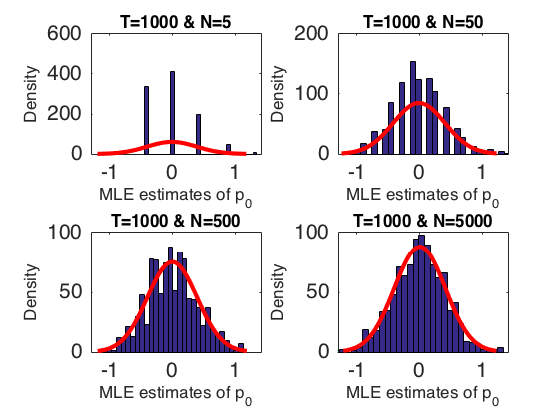

In [7]:
%Generate the histogram of the monte-carlo exercise with a 
%normal distribution super-imposed to see how the sample
%sizes are in relation to the normal. We will create
%subplots.

%First, let's set the bins (how the data is grouped)
bins=30;

%Second, let's find the global minimum and the maximum across 
%all the sameple sizes to set the same axis across all 
%the subplots beta_sim_1 to more easily compare how the dispersion
%(shape of the bell curve) of the estimates change as N changes. 
%Since we have two dimensions we should use nested min and max 
%statements to get the global value.

x_axis_min = min(min(p_centered));
x_axis_max = max(max(p_centered));

%Finally, we run through a loop across the columns of p_centered
%to generate a plot of the distribution of each column (so there 
%will be 4 subplots).

for i=1:size(N,1)

    subplot(2,2,i);
    histfit(p_centered(:,i),bins)
    title(['T=1000 & N=' num2str(N(i))], 'FontSize',8)
    xlabel('MLE estimates of p_0','FontSize',8)
    ylabel('Density', 'FontSize',8)
    xlim([x_axis_min x_axis_max])
    
end

As we can see, as the sample size increases the histogram looks much more normal. 

In [8]:
delete(gcp('nocreate'))

Parallel pool using the 'local' profile is shutting down.


# Problem 6

## Estimation of the ARCH(1) model

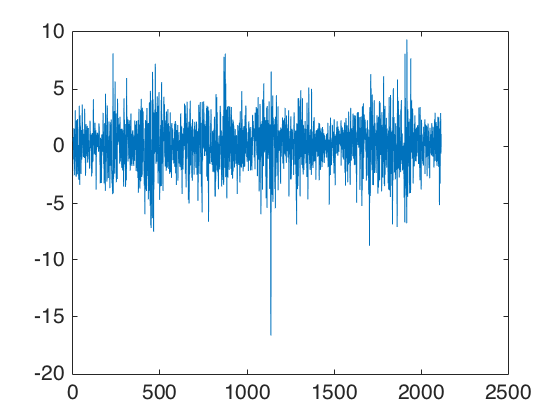

> In fminunc (line 402)

Local minimum possible.

fminunc stopped because the size of the current step is less than
the default value of the step size tolerance.



ARCH(1) results for NYSEWK data set (fminunc)
the estimate
    0.1659
    3.1691
    0.2539

the logL value  -4.4647e+03

BIC value   8.9523e+03

AIC value   8.9323e+03


Local minimum possible. Constraints satisfied.

fmincon stopped because the size of the current step is less than
the default value of the step size tolerance and constraints are 
satisfied to within the default value of the constraint tolerance.



ARCH(1) results for NYSEWK data set (fmincon - impose stationarity) 
the estimate
    0.1659
    3.1691
    0.2539

the logL value  -4.4647e+03


Local minimum possible. Constraints satisfied.

fmincon stopped because the size of the current step is less than
the default value of the step size tolerance and constraints are 
satisfied to within the default value of the constraint tolerance.



ARCH(1) results fo

In [24]:
usematlab = true;

% weekly close price of NSYE, data provided with GRETL
load nysewk.mat;
n = size(nysewk);
y = 100 * log( nysewk(2:n) ./ nysewk(1:n-1) );
data = y;
plot(y);

%%%%%%%%%%%%%%% Unconstrained maximization of logL  %%%%%%%%%%%
% note that the objective has a minus sign in front, as fminunc
% minimizes, but we want to maximize the logL
thetastart = [mean(y); var(y); 0.1];
[thetahat, logL] = fminunc(@(theta) -arch1(theta, data), thetastart);

logL = -logL; % re-convert

%%%%%%%%%%%%%%%%   Results   %%%%%%%%%%%%%%%%
fprintf('ARCH(1) results for NYSEWK data set (fminunc)\n');

fprintf('the estimate\n');
disp(thetahat);

fprintf('the logL value');
disp(logL);

BIC = -2*logL + size(thetahat,1)*log(size(y,1));
AIC = -2*logL + size(thetahat,1);
fprintf('BIC value');
disp(BIC);
fprintf('AIC value');
disp(AIC);

%%%%%%%%%%%%%%% Constrained maximization of logL  %%%%%%%%%%%
%  ARCH model needs parameter restrictions for stationariry and positive variance
%  fmincon can be used to impose them
lb = [-Inf; 0; 0];
ub = [Inf; Inf; 1];
if usematlab
  [thetahat, logL] = fmincon(@(theta) -arch1(theta, data), thetastart, [],[], [],[], lb, ub);
else
  [thetahat, logL] = sqp(thetahat, @(theta) -arch1(theta,data),[], [], lb, ub); %Octave replacement for fmincon
end

logL_UR = -logL; % re-convert

%%%%%%%%%%%%%%%%   Results   %%%%%%%%%%%%%%%%
fprintf('ARCH(1) results for NYSEWK data set (fmincon - impose stationarity) \n');

fprintf('the estimate\n');
disp(thetahat);

fprintf('the logL value');
disp(logL_UR);

%%%%%%%% here's an example of a binding constraint: use the results to do LR test   
R = [0 1 1]; % a silly constraint: make last 2 coefficients add to 2.5
r = 2.5;
lb = [-Inf; 0; 0];
ub = [Inf; Inf; 1];
if usematlab
  [thetahat_r, logL] = fmincon(@(theta) -arch1(theta, data), thetastart, [],[],R,r, lb, ub);
else
  [thetahat_r, logL] = sqp(thetahat, @(theta) -arch1(theta,data),@(theta) R*theta-r, [], lb, ub); %Octave replacement for fmincon
end
logL_R = -logL; % re-convert

%%%%%%%%%%%%%%%%   Results   %%%%%%%%%%%%%%%%
fprintf('ARCH(1) results for NYSEWK data set (fmincon - impose silly restriction) \n');

fprintf('the estimate\n');
disp(thetahat_r);

fprintf('the logL value');
disp(logL_R);

fprintf('the LR test statistic');
disp(2*(logL_UR-logL_R));


## Estimation of the GARCH(1,1) model

In [25]:
%%
%%%%%%%%%%%%%%% Unconstrained maximization of logL  %%%%%%%%%%%
% note that the objective has a minus sign in front, as fminunc
% minimizes, but we want to maximize the logL
thetastart = [mean(y); var(y); 0.1; 0.1];
[thetahat, logL] = fminunc(@(theta) -garch11(theta, data), thetastart);

logL = -logL; % re-convert

%%%%%%%%%%%%%%%%   Results   %%%%%%%%%%%%%%%%
fprintf('GARCH(1,1) results for NYSEWK data set (fminunc)\n');

fprintf('the estimate\n');
disp(thetahat);

fprintf('the logL value');
disp(logL);

BIC = -2*logL + size(thetahat,1)*log(size(y,1));
AIC = -2*logL + size(thetahat,1);
fprintf('BIC value');
disp(BIC);
fprintf('AIC value');
disp(AIC);


> In fminunc (line 402)

Local minimum possible.

fminunc stopped because the size of the current step is less than
the default value of the step size tolerance.



GARCH(1,1) results for NYSEWK data set (fminunc)
the estimate
    0.1769
    0.1602
    0.1125
    0.8533

the logL value  -4.3974e+03

BIC value   8.8254e+03

AIC value   8.7988e+03


## Estimation of the ARCH(4) model

In [27]:
usematlab = true;
% Arch1Example results for start values
thetastart = [0.16; 3.17; 0.25; 0;0;0];

%%%%%%%%%%%%%%% Constrained maximization of logL  %%%%%%%%%%%
%  ARCH model needs parameter restrictions for stationariry and positive variance
%  fmincon can be used to impose them
lb = [-Inf; 0; 0; 0; 0; 0];
ub = [Inf; Inf; 1;1;1;1];
R = [0 0 1 1 1 1]; % 
r = 1;
if usematlab
  [thetahat, logL] = fmincon(@(theta) -arch4(theta, data), thetastart, R,r, [],[], lb, ub);
else
  [thetahat, logL] = sqp(thetastart, @(theta) -arch4(theta,data),[], @(theta) r-R*theta, lb, ub); %Octave replacement for fmincon
end
logL = -logL; % re-convert

%%%%%%%%%%%%%%%%   Results   %%%%%%%%%%%%%%%%
fprintf('ARCH(4) results for NYSEWK data set (fmincon - impose stationarity) \n');

fprintf('the estimate\n');
disp(thetahat);

fprintf('the logL value');
disp(logL);


BIC = -2*logL + size(thetahat,1)*log(size(y,1));
AIC = -2*logL + size(thetahat,1);
fprintf('BIC value');
disp(BIC);
fprintf('AIC value');
disp(AIC);


Local minimum possible. Constraints satisfied.

fmincon stopped because the size of the current step is less than
the default value of the step size tolerance and constraints are 
satisfied to within the default value of the constraint tolerance.



ARCH(4) results for NYSEWK data set (fmincon - impose stationarity) 
the estimate
    0.1932
    2.2139
    0.2183
    0.1158
    0.0627
    0.0974

the logL value  -4.4302e+03

BIC value   8.9063e+03

AIC value   8.8664e+03


## Analysis

Regarding stationary restrictions (only for ARCH models): they hold, implying the distributions are stationary (as they should be).

Regarding the likelihood values: We see that the GARCH(1,1) model has the largest likelihood value. However, given that these models do not have the same number of parameters we need a measure that does not rely on the number of parameters. 

I have also calculated the AIC as well as the supplied BIC. We see the following patterns for both the AIC and BIC:
\begin{equation*}
\text{GARCH}(1,1)<\text{ARCH}(4)<\text{ARCH}(1)
\end{equation*}
So in terms of model selection crieria, since we pick the model with the smallest AIC or BIC we would choose the GARCH(1,1) model. 